# Data Mining Audio Classification

Dataset used - https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs/data

## Loading the dataset

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/archive (15).zip
/content/.config/gce
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/config_sentinel
/content/.config/default_configs.db
/content/.config/active_config
/content/.config/.last_survey_prompt.yaml
/content/.config/logs/2023.10.30/13.25.18.782442.log
/content/.config/logs/2023.10.30/13.24.59.438179.log
/content/.config/logs/2023.10.30/13.25.19.608259.log
/content/.config/logs/2023.10.30/13.24.49.541401.log
/content/.config/logs/2023.10.30/13.24.22.859875.log
/content/.config/logs/2023.10.30/13.25.08.387117.log
/content/.config/configurations/config_default
/content/extracted_data/train_test_split.csv
/content/extracted_data/utils.py
/content/extracted_data/cats_dogs/cat_127.wav
/content/extracted_data/cats_dogs/cat_64.wav
/content/extracted_data/cats_dogs/dog_barking_40.wav
/content/extracted_data/cats_dogs/cat_80.wav
/content/extracted_data/cats_dogs/cat_28.wav
/content/extracted_data/cats_dogs/dog_barking_29.wa

In [28]:
# Extract the ZIP file
zip_path = "/content/archive (15).zip"
extract_folder = "/content/audio-cats-and-dogs"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# List the contents of the extracted folder
extracted_files = os.listdir(extract_folder)
extracted_files

['train_test_split.csv', 'cats_dogs', 'utils.py']

### Importing Libraries

In [9]:
# importing all the modules
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import zipfile

## Setting up paths for directories

In [29]:
# setting up the data directory
DATA_DIR="/content/extracted_data/cats_dogs"

# setting up path for train and test data
train_dir=DATA_DIR+"/train"
test_dir=DATA_DIR+"/test"

In [30]:

# get the train files
file_train = tf.io.gfile.glob(train_dir + '/*/*')
# shuffle
file_train = tf.random.shuffle(file_train)

train_ds=file_train

# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle
file_test = tf.random.shuffle(file_test)


test_ds=file_test
print("Shape of train data:- ", train_ds.shape)
print("Shape of test data:- ",file_test.shape)


Shape of train data:-  (210,)
Shape of test data:-  (67,)


#### Splitting into train and test data

In [12]:

import pandas as pd

# Load the train_test_split.csv file into a DataFrame
train_test_split_df = pd.read_csv(os.path.join(extract_folder, 'train_test_split.csv'))

# Display the first few rows of the DataFrame
train_test_split_df.head()



# test_ds=file_test
# print("Shape of train data:- ", train_ds.shape)
# print("Shape of test data:- ",file_test.shape)

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


## Exploratory Data Analysis (EDA)

#### Distribution of Audio Files

In [22]:
# Count the number of audio files for each category
train_cat_count = train_test_split_df["train_cat"].dropna().shape[0]
train_dog_count = train_test_split_df["train_dog"].dropna().shape[0]
test_cat_count = train_test_split_df["test_cat"].dropna().shape[0]
test_dog_count = train_test_split_df["test_dog"].dropna().shape[0]

# Create a summary dataframe
audio_file_distribution = pd.DataFrame({
    "Category": ["Train (Cat)", "Train (Dog)", "Test (Cat)", "Test (Dog)"],
    "Count": [train_cat_count, train_dog_count, test_cat_count, test_dog_count]
})

audio_file_distribution


,Category,Count
0,Train (Cat),115
1,Train (Dog),64
2,Test (Cat),49
3,Test (Dog),49


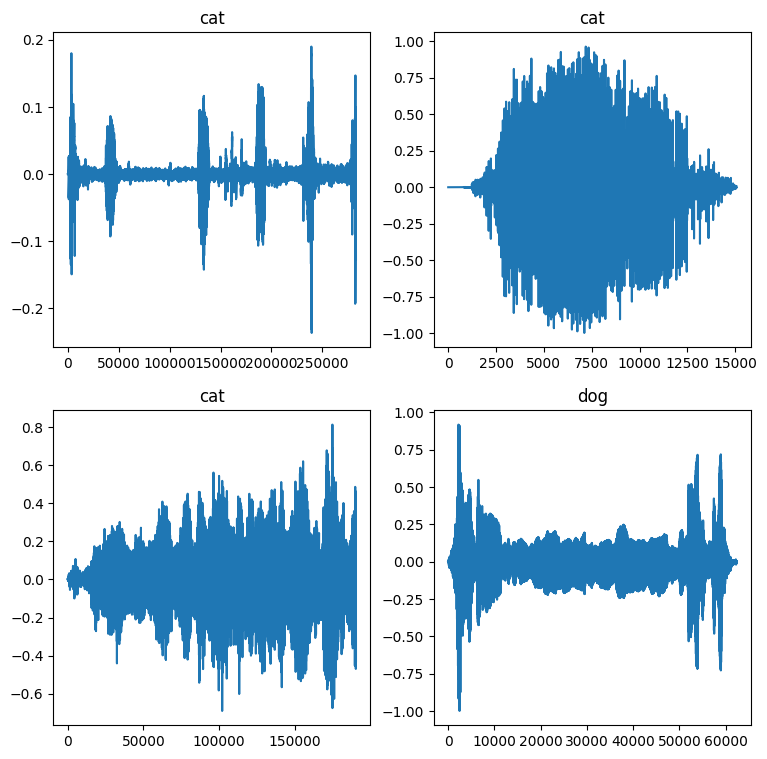

In [33]:
# number of rows and columns of plot
row,col = 2,2
n = row*col
fig, axs = plt.subplots(row, col, figsize=(9, 9))

# plotting waveforms
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // col
  c = i % col
  ax = axs[r][c]
  ax.plot(audio.numpy())

  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Audio File Duration Analysis

#### Get waveform and label associated

In [32]:
# Function to get waveform and it's label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binalry file
  audio_binary = tf.io.read_file(file)
  # decode the file
  audio, _ = tf.audio.decode_wav(audio_binary)
  # sqeeze tha audio
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, lab

# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

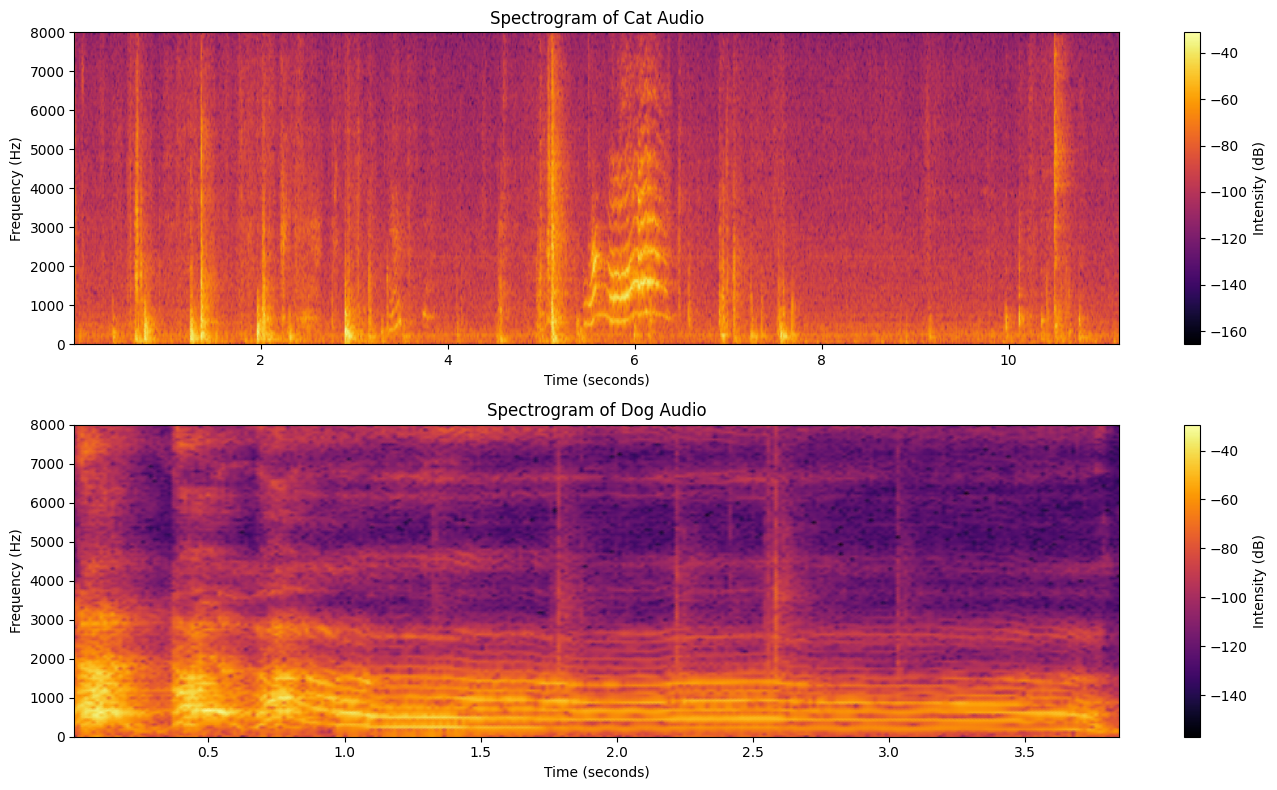

In [15]:
from scipy.signal import spectrogram

def compute_spectrogram_v2(audio, sr):
    """Compute the magnitude spectrogram of an audio signal using scipy's spectrogram function."""
    freqs, times, Sxx = spectrogram(audio, fs=sr)
    return freqs, times, Sxx

# Compute the spectrograms
cat_freqs, cat_times, cat_Sxx = compute_spectrogram_v2(cat_audio, sr_cat)
dog_freqs, dog_times, dog_Sxx = compute_spectrogram_v2(dog_audio, sr_dog)

# Plot the spectrograms
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.pcolormesh(cat_times, cat_freqs, 10 * np.log10(cat_Sxx), shading='gouraud', cmap='inferno')
plt.colorbar(label='Intensity (dB)')
plt.title('Spectrogram of Cat Audio')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

plt.subplot(2, 1, 2)
plt.pcolormesh(dog_times, dog_freqs, 10 * np.log10(dog_Sxx), shading='gouraud', cmap='inferno')
plt.colorbar(label='Intensity (dB)')
plt.title('Spectrogram of Dog Audio')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


### Construct Spectrogram

In [34]:
# function to get the spectogram and the labels
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

# get all the labels from the dataset
labels = np.array(["cat","dog"])

# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)

<ipython-input-35-fd1c40525c7b>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


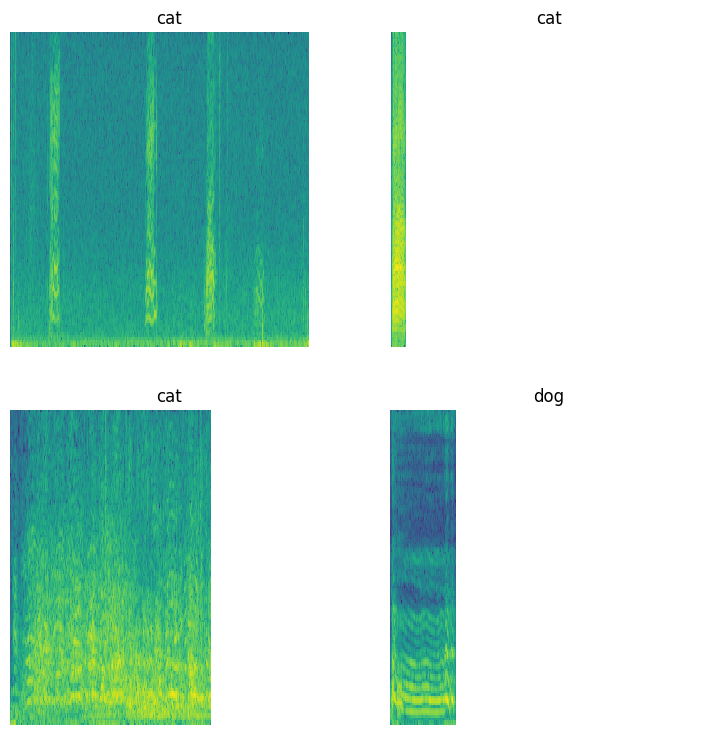

In [35]:
# function to plot the spectogram
def plot_spect(spectrogram, ax):
  # Converting frequencies to log and transpose to repesent time on x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# plot using a subplot
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # function call
  plot_spect(np.squeeze(spectrogram.numpy()), ax)
  # set the title label
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')
plt.show()

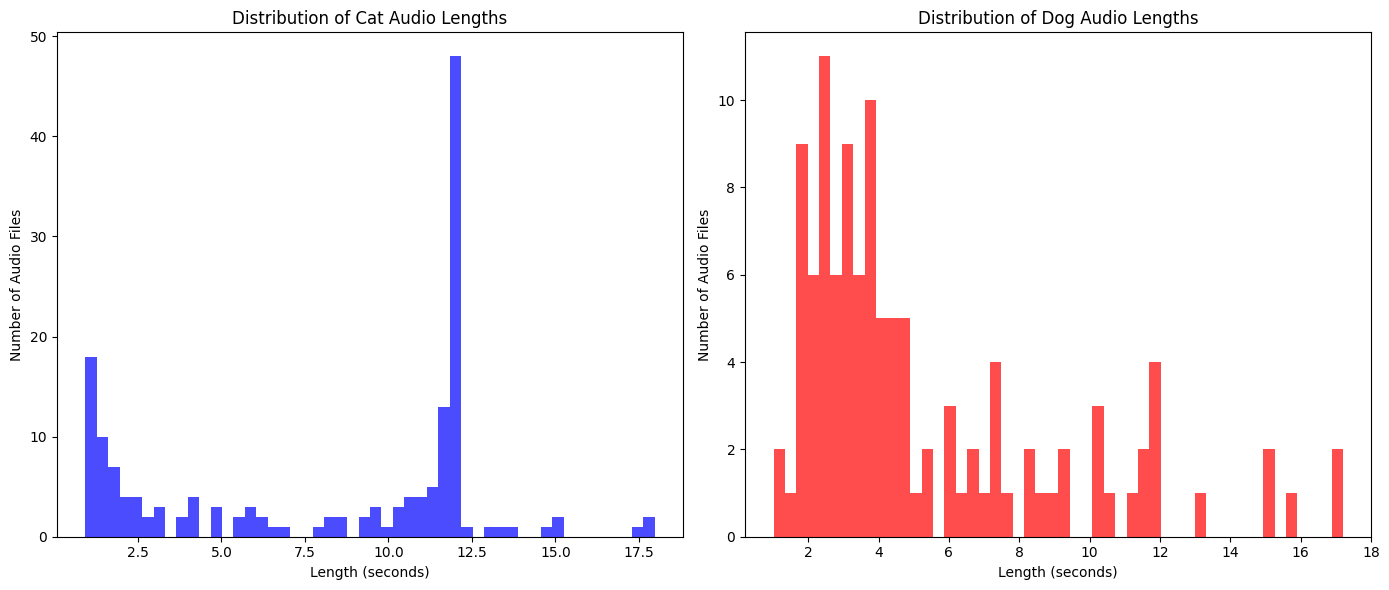

In [20]:
# Plot the distribution of audio lengths for cats and dogs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(cat_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Cat Audio Lengths')
plt.xlabel('Length (seconds)')
plt.ylabel('Number of Audio Files')

plt.subplot(1, 2, 2)
plt.hist(dog_lengths, bins=50, color='red', alpha=0.7)
plt.title('Distribution of Dog Audio Lengths')
plt.xlabel('Length (seconds)')
plt.ylabel('Number of Audio Files')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [36]:
# function to preprocess the data
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

## Built the model

In [37]:
# initialize a batch size
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

In [38]:
# building the model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# adding layers
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2726, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                         

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [40]:
EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS,
)

Epoch 1/15
4/4 [==============================] - 6s 882ms/step - loss: 0.6850 - accuracy: 0.5429
Epoch 2/15
4/4 [==============================] - 1s 184ms/step - loss: 0.5596 - accuracy: 0.8048
Epoch 3/15
4/4 [==============================] - 1s 166ms/step - loss: 0.5387 - accuracy: 0.8238
Epoch 4/15
4/4 [==============================] - 1s 173ms/step - loss: 0.4764 - accuracy: 0.8476
Epoch 5/15
4/4 [==============================] - 1s 171ms/step - loss: 0.4193 - accuracy: 0.8381
Epoch 6/15
4/4 [==============================] - 1s 172ms/step - loss: 0.3608 - accuracy: 0.8619
Epoch 7/15
4/4 [==============================] - 2s 569ms/step - loss: 0.3082 - accuracy: 0.8810
Epoch 8/15
4/4 [==============================] - 1s 215ms/step - loss: 0.2802 - accuracy: 0.9143
Epoch 9/15
4/4 [==============================] - 1s 173ms/step - loss: 0.2392 - accuracy: 0.9190
Epoch 10/15
4/4 [==============================] - 1s 171ms/step - loss: 0.1871 - accuracy: 0.9333
Epoch 11/15
4/4 [==

## Testing The Model

In [41]:
# initialize empty list to save the audio and labels
t_audio = []
t_labels = []

# load in the labels and audio from test dataset
for audio, label in test_ds:
  t_audio.append(audio.numpy())
  t_labels.append(label.numpy())

# convert the lists to a numpy array
t_audio = np.array(t_audio)
t_labels = np.array(t_labels)

In [42]:
# Feed in the data for prediction
y_pred = np.argmax(model.predict(t_audio), axis=1)

# store the original labels for testing the accuracy
y_true = t_labels

# get the testing accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 22ms/step
Test set accuracy: 60%


## Confusion matrix

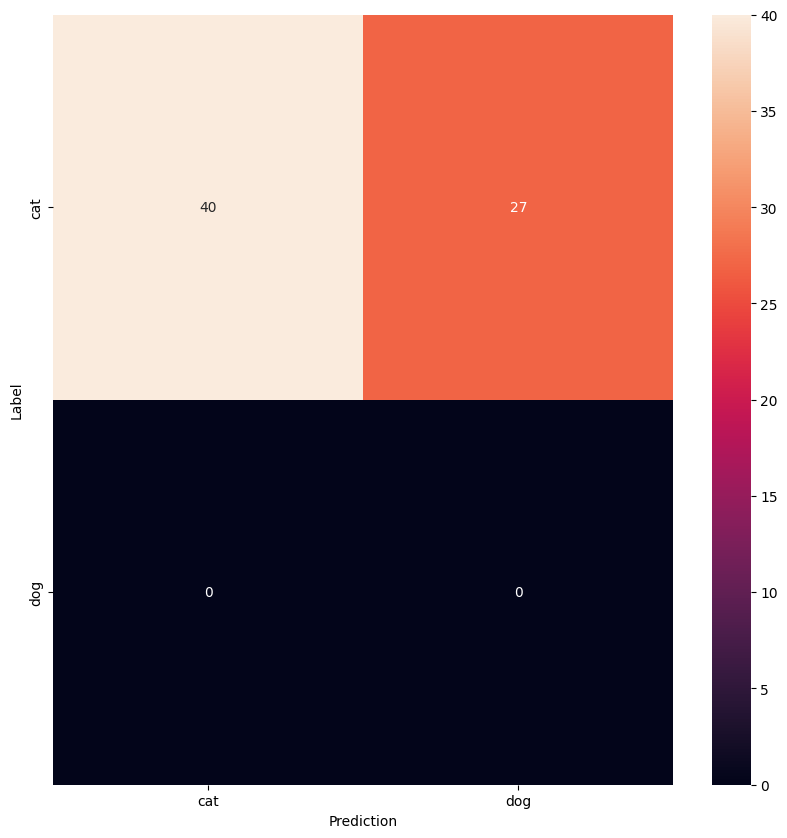

In [43]:
conf_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
seaborn.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()